In [17]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from copy import copy
from collections import defaultdict
from sklearn.metrics import adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import SpectralClustering, DBSCAN
from sklearn_extra.cluster import KMedoids

from joblib import Parallel, delayed

from umap import UMAP
from hdbscan import validity_index as DBCV
from hdbscan import HDBSCAN
from clustering_utils import clustering_by_methods, clustering, plot_clustering_scatter, metrics_formatting

from IPython.display import clear_output

import warnings
warnings.simplefilter("ignore")

# Load data

In [18]:
clustering_results_root = f'results/clustering_cpt-0.01/'

if not os.path.exists(clustering_results_root):
    os.makedirs(clustering_results_root)

data_orig = {}
for dataset_name in tqdm(['AGP', 'HMP']):
    for tax in ['o', 'f', 'g']: 
        dataframe = pd.read_csv(f'./data_processed/{dataset_name}_{tax}.csv', sep=',')
        label = f'{dataset_name}_{tax}'
        data_orig[label] = dataframe.drop('Unnamed: 0', axis=1).values
    
data_pca = {}
for dataset_name in tqdm(['AGP', 'HMP']):
    for tax in ['o', 'f', 'g']: 
        label = f'{dataset_name}_{tax}'
        data_pca[label] = np.genfromtxt(f'./results/pca/{label}', delimiter=';')
        
data_embeddings = defaultdict(dict)
embeddings_path = './results/embeddings'
    
for emb_path in glob.glob(embeddings_path + '/*'):
    label_info = emb_path.split('/')[-1].split('.')[0]
    dataset, tax, embedding_type = label_info.split('_')
    d = np.load(emb_path, allow_pickle=True).item()
    label = dataset + '_' + tax
    data_embeddings[embedding_type][label] = d['Z_']
    
distance_root = 'distances_processed'
distances_names = ['L1', 'L2', 'JS', 'BC']

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s]


# Load synthetic data

In [24]:
# clustering_results_root = f'results/clustering_cpt-0.01_synthetic/'

# if not os.path.exists(clustering_results_root):
#     os.makedirs(clustering_results_root)

# targets_orig = {}
# for path in glob.glob('data/synthetic/*'):
#     dataframe = pd.read_csv(path, index_col=0)
#     label = path.split('/')[-1].split('.')[0]
#     targets_orig[label] = dataframe['target'].values
    
# data_orig = {}
# for path in glob.glob('data_processed/synthetic/*'):
#     dataframe = pd.read_csv(path, index_col=0)
#     label = path.split('/')[-1].split('.')[0]
#     data_orig[label] = dataframe.values

# data_pca = {}
# for path in tqdm(glob.glob('./results/pca/synthetic/*')):
#     label = path.split('/')[-1]
#     data_pca[label] = np.genfromtxt(path, delimiter = ';')
        
# data_embeddings = defaultdict(dict)
# embeddings_path = './results/embeddings_synthetic'
# inliers_indexes_all = {}
# for emb_path in glob.glob(embeddings_path + '/*'):
#     label_info = emb_path.split('/')[-1].split('.')[0]
#     dataset, tax, embedding_type = label_info.split('_')
#     d = np.load(emb_path, allow_pickle=True).item()
#     label = dataset + '_' + tax
#     data_embeddings[embedding_type][label] = d['Z_']
#     inliers_indexes_all[label_info] = d['inliers_indexes_mae']
    
# distance_root = 'distances_processed_synth'
# # only L1 and L2 distances are supported
# distances_names = ['L1', 'L2']

# Clustering: precomputed distances

In [79]:
distances_orig = defaultdict(dict)
for metric_name in distances_names:
    for label in data_orig.keys(): 
        distances_orig[metric_name][label] = np.load(os.path.join(distance_root,\
                                                                  f'orig_{metric_name}_{label}.npy'), 
                                                     allow_pickle=True)

In [80]:
class SpectralClustering_prec:
    def __init__(self, *args, **kwargs):
        self.method = SpectralClustering(*args, **kwargs, affinity='precomputed', random_state=42)
    def fit_predict(self, X):
        '''
        X - pairwise_distance matrix
        '''
        A = np.exp(-self.method.gamma * np.abs(X))
        return self.method.fit_predict(A)  
    
    
class DBSCAN_eps:
    def __init__(self, *args, **kwargs):
        self.method = DBSCAN(*args, **kwargs, random_state=42)
    def fit_predict(self, X):
        return self.method.fit_predict(X) 

In [86]:
methods_dict_distances = {
                           'HDBSCAN':[HDBSCAN, 
                              {'min_cluster_size':[5,10,25,50], 
                               'min_samples':[None,5,10,15,20],
                               'metric':['precomputed'],
                               'core_dist_n_jobs':[1]}
                               ],
                           'KMedoids':[KMedoids, 
                                       {'n_clusters':np.arange(2, 10, 1),
                                        'method':['pam'],
                                        'metric':['precomputed'],
                                        'init':['k-medoids++'],
                                        'random_state':[42]}],
                           'SpectralClustering':[SpectralClustering_prec, 
                                                 {'n_clusters':np.arange(2, 10, 1), 
                                                  'gamma':[1., 5, 10, 15, 20, 25, 30],
                                                  'eigen_tol':[1e-4]}]
                        }

In [ ]:
for distance_name, distance_dict in tqdm(distances_orig.items()):

    distance_cluster_metrics = defaultdict(dict)
    distance_cluster_results = defaultdict(dict)
    
    # list of lists of pairs [cluster_metrics, cluster_results]
    clustering_data_results = Parallel(n_jobs=len(distance_dict),
                                      mmap_mode='w+')(delayed(clustering_by_methods)(data.astype('double'), 
                                                                                   methods_dict_distances,
                                                                                   precomputed=True,
                                                                                   d=data_orig[label].shape[1])
                                                            for label, data in distance_dict.items())

    # create compatible metrics dicts
    for i,label in enumerate(distance_dict.keys()):
        for j, method_name in enumerate(methods_dict_distances.keys()):
            distance_cluster_metrics[label][method_name] = clustering_data_results[i][j][0]
            distance_cluster_results[label][method_name] = clustering_data_results[i][j][1]

    np.save(os.path.join(clustering_results_root, f'{distance_name}_cluster_metrics'), distance_cluster_metrics)
    np.save(os.path.join(clustering_results_root, f'{distance_name}_cluster_results'), distance_cluster_results)
    
clear_output()

  0%|                                                                                                                                                  | 0/4 [00:00<?, ?it/s]/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/hdbscan/validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/hdbscan/validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/hdbscan/validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/hdbscan/validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
/home/ibulygin/minicond

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/hdbscan/validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/hdbscan/validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/hdbscan/validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/hdbscan/validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, 

/nfs/tom/ibulygin/Human-Gut-Microbiome-Analysis/clustering_utils.py:330: RuntimeWarning: invalid value encountered in long_scalars
  count /= (n_k * (n_k - 1)) # divided by the total number of pairs in cluster
/nfs/tom/ibulygin/Human-Gut-Microbiome-Analysis/clustering_utils.py:330: RuntimeWarning: invalid value encountered in long_scalars
  count /= (n_k * (n_k - 1)) # divided by the total number of pairs in cluster
/nfs/tom/ibulygin/Human-Gut-Microbiome-Analysis/clustering_utils.py:330: RuntimeWarning: invalid value encountered in long_scalars
  count /= (n_k * (n_k - 1)) # divided by the total number of pairs in cluster
/nfs/tom/ibulygin/Human-Gut-Microbiome-Analysis/clustering_utils.py:330: RuntimeWarning: invalid value encountered in long_scalars
  count /= (n_k * (n_k - 1)) # divided by the total number of pairs in cluster
/nfs/tom/ibulygin/Human-Gut-Microbiome-Analysis/clustering_utils.py:330: RuntimeWarning: invalid value encountered in long_scalars
  count /= (n_k * (n_k - 1)) 

# Clustering: PCA

In [95]:
DBIND_THRESHOLD = 0.6 # Original paper
DBIND_MAX = 3.
SILHOUETTE_THRESH = 0.5 # Koren et al

PS_THRESHOLD = 0.8 # Koren et al 
DBCV_THRESHOLD = 0.0 # Ours 

DATA_PRESERVED_THRESHOLD = 0.9 # Ours

In [96]:
methods_dict = {'HDBSCAN':[HDBSCAN, 
                          {'min_cluster_size':[5,10,25,50], 
                           'min_samples':[None,5,10,15,20],
                           'core_dist_n_jobs':[1],
                           'random_state':[42]}],
               'KMedoids':[KMedoids, 
                           {'n_clusters':np.arange(2, 10, 1),
                            'method':['pam'],
                            'init':['k-medoids++'],
                            'random_state':[42]}],
               'SpectralClustering':[SpectralClustering, 
                                     {'n_clusters':np.arange(2, 10, 1), 
                                     'affinity':['nearest_neighbors'],
                                     'n_neighbors': [3,5,15,25], 
                                     'eigen_tol':[1e-4],
                                     'random_state':[42]}]}

In [97]:
pca_cluster_metrics = defaultdict(dict)
pca_cluster_results = defaultdict(dict)

clustering_data_results = Parallel(n_jobs=len(data_pca),
                                  mmap_mode='w+')(delayed(clustering_by_methods)(data.astype('double'), 
                                                                                methods_dict) \
                                                                for label, data in tqdm(data_pca.items()))


# create compatible metrics dicts
for i,label in enumerate(data_pca.keys()):
    for j, method_name in enumerate(methods_dict.keys()):
        pca_cluster_metrics[label][method_name] = clustering_data_results[i][j][0]
        pca_cluster_results[label][method_name] = clustering_data_results[i][j][1]


np.save(os.path.join(clustering_results_root,'pca_cluster_metrics'), pca_cluster_metrics)
np.save(os.path.join(clustering_results_root,'pca_cluster_results'), pca_cluster_results)

clear_output()

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

# Clustering: embeddings 

In [ ]:
for embedding_type, embeddings in tqdm(data_embeddings.items()):
    
    embeddings_cluster_metrics = defaultdict(dict)
    embeddings_cluster_results = defaultdict(dict)
    
    
    # it returns [[cluster_metrics, cluster_results],...] list for each embedding dataset
    clustering_data_results = Parallel(n_jobs=len(embeddings),
                                      mmap_mode='w+')(delayed(clustering_by_methods)(data.astype('double'), 
                                                                                      methods_dict) \
                                                                 for _, data in embeddings.items())
    
    # create compatible metrics dicts
    for i,label in enumerate(embeddings.keys()):
        for j, method_name in enumerate(methods_dict.keys()):
            embeddings_cluster_metrics[label][method_name] = clustering_data_results[i][j][0]
            embeddings_cluster_results[label][method_name] = clustering_data_results[i][j][1]

            
    np.save(os.path.join(clustering_results_root, f'{embedding_type}_cluster_metrics'), embeddings_cluster_metrics)
    np.save(os.path.join(clustering_results_root, f'{embedding_type}_cluster_results'), embeddings_cluster_results)
    
clear_output()

  0%|                                                                                                                                                  | 0/4 [00:00<?, ?it/s]/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not wo

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

 25%|█████████████████████████████████▌                                                                                                    | 1/4 [30:09<1:30:28, 1809.57s/it]/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not wo

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

/nfs/tom/ibulygin/Human-Gut-Microbiome-Analysis/clustering_utils.py:330: RuntimeWarning: invalid value encountered in long_scalars
  count /= (n_k * (n_k - 1)) # divided by the total number of pairs in cluster
/nfs/tom/ibulygin/Human-Gut-Microbiome-Analysis/clustering_utils.py:330: RuntimeWarning: invalid value encountered in long_scalars
  count /= (n_k * (n_k - 1)) # divided by the total number of pairs in cluster
/nfs/tom/ibulygin/Human-Gut-Microbiome-Analysis/clustering_utils.py:330: RuntimeWarning: invalid value encountered in long_scalars
  count /= (n_k * (n_k - 1)) # divided by the total number of pairs in cluster
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, sp

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 3/4 [1:23:50<27:42, 1662.80s/it]/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not wo

/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not full

/nfs/tom/ibulygin/Human-Gut-Microbiome-Analysis/clustering_utils.py:330: RuntimeWarning: invalid value encountered in long_scalars
  count /= (n_k * (n_k - 1)) # divided by the total number of pairs in cluster
/nfs/tom/ibulygin/Human-Gut-Microbiome-Analysis/clustering_utils.py:330: RuntimeWarning: invalid value encountered in long_scalars
  count /= (n_k * (n_k - 1)) # divided by the total number of pairs in cluster
/nfs/tom/ibulygin/Human-Gut-Microbiome-Analysis/clustering_utils.py:330: RuntimeWarning: invalid value encountered in long_scalars
  count /= (n_k * (n_k - 1)) # divided by the total number of pairs in cluster
/nfs/tom/ibulygin/Human-Gut-Microbiome-Analysis/clustering_utils.py:330: RuntimeWarning: invalid value encountered in long_scalars
  count /= (n_k * (n_k - 1)) # divided by the total number of pairs in cluster
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectra

In [126]:
ls -la results/clustering_cpt-0.01/

total 115492
drwxr-xr-x 2 ibulygin users     4096 июл  6 20:53 ./
drwxr-xr-x 6 ibulygin users     4096 июн 18 21:24 ../
-rw-r--r-- 1 ibulygin users   101533 июл  5 19:53 BC_cluster_metrics.npy
-rw-r--r-- 1 ibulygin users 14237808 июл  5 19:53 BC_cluster_results.npy
-rw-r--r-- 1 ibulygin users   108527 июл  6 19:58 isomap_cluster_metrics.npy
-rw-r--r-- 1 ibulygin users 14026660 июл  6 19:58 isomap_cluster_results.npy
-rw-r--r-- 1 ibulygin users    47941 июл  5 18:26 JS_cluster_metrics.npy
-rw-r--r-- 1 ibulygin users  7032088 июл  5 18:26 JS_cluster_results.npy
-rw-r--r-- 1 ibulygin users    68012 июл  5 15:32 L1_cluster_metrics.npy
-rw-r--r-- 1 ibulygin users  9545579 июл  5 15:32 L1_cluster_results.npy
-rw-r--r-- 1 ibulygin users    92797 июл  5 16:58 L2_cluster_metrics.npy
-rw-r--r-- 1 ibulygin users 13034299 июл  5 16:58 L2_cluster_results.npy
-rw-r--r-- 1 ibulygin users    98154 июл  6 19:32 lle_cluster_metrics.npy
-rw-r--r-- 1 ibulygin users 12927209 июл  6 19:32 lle_cluster_result

In [127]:
ls -la ./results/embeddings | grep spectral

-rw-r--r-- 1 ibulygin users  7758306 июн 29 22:11 AGP_f_spectral.npy
-rw-r--r-- 1 ibulygin users 13739498 июн 29 22:22 AGP_g_spectral.npy
-rw-r--r-- 1 ibulygin users  4440154 июн 29 22:18 AGP_o_spectral.npy
-rw-r--r-- 1 ibulygin users  3617008 июн 29 22:10 HMP_f_spectral.npy
-rw-r--r-- 1 ibulygin users  6188698 июн 29 22:08 HMP_g_spectral.npy
-rw-r--r-- 1 ibulygin users  2062530 июн 29 22:16 HMP_o_spectral.npy


# Plot clustering results

In [101]:
methods = np.unique(list(map(lambda x: x.split('_')[0], os.listdir(clustering_results_root))))

In [102]:
# see paper for metrics thresholds explanation
DBIND_THRESHOLD = 0.6
DBIND_MAX = 3.
SILHOUETTE_THRESH = 0.5

PS_THRESHOLD = 0.8
DBCV_THRESHOLD = 0.0

DATA_PRESERVED_THRESHOLD = 0.9

# Synthetic data
uncomment all cells in this section to use code for figures generation

In [103]:
# df = []
# for mf_method in methods: # data type 'L1', 'L2', .
    
#     clustering_metrics_path = os.path.join(clustering_results_root, f'{mf_method}_cluster_metrics.npy')
#     clustreing_results_path = os.path.join(clustering_results_root, f'{mf_method}_cluster_results.npy')
    
#     cluster_metrics = np.load(clustering_metrics_path, allow_pickle=True).item()
#     cluster_results = np.load(clustreing_results_path, allow_pickle=True).item()

#     for label, label_metrics in cluster_metrics.items(): # 'clust2_dim180', ...
#         for method_name, label_method_results in label_metrics.items(): # 'HDBSCAN', 'KMedoids', ...
#             for n_clusters, cluster_results_label_method in label_method_results.items(): # 2,3,4,...

#                 y = targets_orig[label]
#                 n_clusters_real = len(np.unique(y)) - 1 # one class corresponds to the noise

#                 for cluster_label_method, cluster_label_method_labels in zip(cluster_results_label_method, 
#                                                                              cluster_results[label][method_name][n_clusters]):
                    
#                     if mf_method in data_embeddings.keys():
#                         inliers = inliers_indexes_all[label + '_' + mf_method]
#                     else:
#                         inliers = np.arange(len(y))

#                     cluster_label_method['method_name'] = method_name   
#                     cluster_label_method['n_clusters'] = n_clusters  
#                     cluster_label_method['n_clusters_real'] = n_clusters_real
#                     cluster_label_method['label'] = label
#                     cluster_label_method['mf_method'] = mf_method
                    
#                     y_ = cluster_label_method_labels['labels']
#                     mask = cluster_label_method_labels['mask']
#                     cluster_label_method['ari'] = adjusted_rand_score(y[inliers][mask], y_)

#                     df.append(cluster_label_method)
                    
# df = pd.DataFrame(df) 

In [104]:
# df_ = df.dropna()
# df_ = df_.query('ari > 0.9 & (n_clusters == n_clusters_real)')
# assert len(np.unique(df_['label'])) == 9 # all datasets were partitioned properly

In [12]:
# plot_clustering_scatter(df_, 
#                         x_metric_name='dbind',
#                         y_metric_name='silh', 
#                         coloring_metric_name='entropy', 
#                         title='Synthetic datasets clustering',
#                         y_threshold=SILHOUETTE_THRESH,
#                         x_threshold=DBIND_THRESHOLD,
#                         y_hue_line=1,
#                         x_hue_line=0)

In [18]:
# ind = df_.query(f'silh >= {SILHOUETTE_THRESH} & dbind <= {DBIND_THRESHOLD} & data_used > {DATA_PRESERVED_THRESHOLD}').groupby('label')['silh'].idxmax().values
# df.loc[ind]

In [11]:
# plot_clustering_scatter(df_, 
#                         x_metric_name='dbcv',
#                         y_metric_name='ps', 
#                         coloring_metric_name='entropy', 
#                         title='Synthetic datasets clustering',
#                         y_threshold=PS_THRESHOLD,
#                         x_threshold=DBCV_THRESHOLD,
#                         y_hue_line=1.2,
#                         x_hue_line=1
#                         )

In [19]:
# ind = df_.query(f'dbcv >= {DBCV_THRESHOLD} & ps >= {PS_THRESHOLD} & data_used > 0.9').groupby('label')['dbcv'].idxmax().values
# df.loc[ind]

# Microbiome data

In [112]:
clustering_metrics_AGP = {}
clustering_metrics_HMP = {}

clustering_results_AGP = {}
clustering_results_HMP = {}

for mf_method in methods:
    
    clustering_metrics_path = os.path.join(clustering_results_root, f'{mf_method}_cluster_metrics.npy')
    clustreing_results_path = os.path.join(clustering_results_root, f'{mf_method}_cluster_results.npy')
    
    cluster_metrics = np.load(clustering_metrics_path, allow_pickle=True).item()
    cluster_results = np.load(clustreing_results_path, allow_pickle=True).item()
    
    # results for each datset
    for label, cluster_metrics_label in cluster_metrics.items():
        #results for each method given dataset
        for cl_method, cluster_metrics_label_method in cluster_metrics_label.items():
            
            if len(cluster_metrics_label_method) == 0:
                print('Empty results for:', mf_method, label, cl_method)
                continue
            cluster_results_label_method = cluster_results[label][cl_method]
            # results for each number of clusters given mehod and dataset
            cluster_metrics_label_method_formatted, cluster_results_label_method_formatted = \
                                                    metrics_formatting(cluster_metrics_label_method,
                                                                       clusters=cluster_results_label_method)
            for n_clusters, cluster_metrics_label_method_n in cluster_metrics_label_method_formatted.items():
                    
                partition_name = '_'.join([mf_method, label, cl_method, str(n_clusters)])

                if 'AGP' in label:
                    clustering_metrics_AGP[partition_name] = cluster_metrics_label_method_n
                    clustering_results_AGP[partition_name] = cluster_results_label_method_formatted[n_clusters]
                elif 'HMP' in label:
                    clustering_metrics_HMP[partition_name] = cluster_metrics_label_method_n
                    clustering_results_HMP[partition_name] = cluster_results_label_method_formatted[n_clusters]
                else:
                    raise RuntimeError('Unrecognized label!')

Empty results for: BC AGP_o HDBSCAN
Empty results for: BC AGP_f HDBSCAN
Empty results for: BC AGP_g HDBSCAN
Empty results for: BC HMP_f HDBSCAN
Empty results for: BC HMP_g HDBSCAN
Empty results for: JS AGP_o HDBSCAN
Empty results for: JS AGP_f HDBSCAN
Empty results for: JS AGP_g HDBSCAN
Empty results for: JS HMP_o HDBSCAN
Empty results for: JS HMP_f HDBSCAN
Empty results for: JS HMP_g HDBSCAN
Empty results for: L1 AGP_o HDBSCAN
Empty results for: L1 AGP_f HDBSCAN
Empty results for: L1 AGP_g HDBSCAN
Empty results for: L1 HMP_f HDBSCAN
Empty results for: L1 HMP_g HDBSCAN
Empty results for: L2 AGP_o HDBSCAN
Empty results for: L2 AGP_f HDBSCAN
Empty results for: L2 AGP_g HDBSCAN
Empty results for: L2 HMP_f HDBSCAN
Empty results for: L2 HMP_g HDBSCAN
Empty results for: isomap AGP_g HDBSCAN
Empty results for: isomap AGP_o HDBSCAN
Empty results for: isomap HMP_g HDBSCAN
Empty results for: lle HMP_g HDBSCAN
Empty results for: lle AGP_o HDBSCAN
Empty results for: lle HMP_f HDBSCAN
Empty results

In [113]:
df_metrics_AGP = pd.DataFrame(clustering_metrics_AGP).T
df_metrics_HMP = pd.DataFrame(clustering_metrics_HMP).T

In [114]:
AGP_mask = (df_metrics_AGP['data_used'] > DATA_PRESERVED_THRESHOLD) & (df_metrics_AGP['dbind'] < DBIND_MAX)  & (~df_metrics_AGP['dbcv'].isna())
HMP_mask = (df_metrics_HMP['data_used'] > DATA_PRESERVED_THRESHOLD) & (df_metrics_HMP['dbind'] < DBIND_MAX)  & (~df_metrics_HMP['dbcv'].isna())

df_metrics_AGP_ = df_metrics_AGP[AGP_mask]
df_metrics_HMP_ = df_metrics_HMP[HMP_mask]

# Davies-Bouldin index and Silhoutte score, entropy coloring

In [116]:
plt.rcParams.update({'font.size': 20, 'axes.titley':1.05})

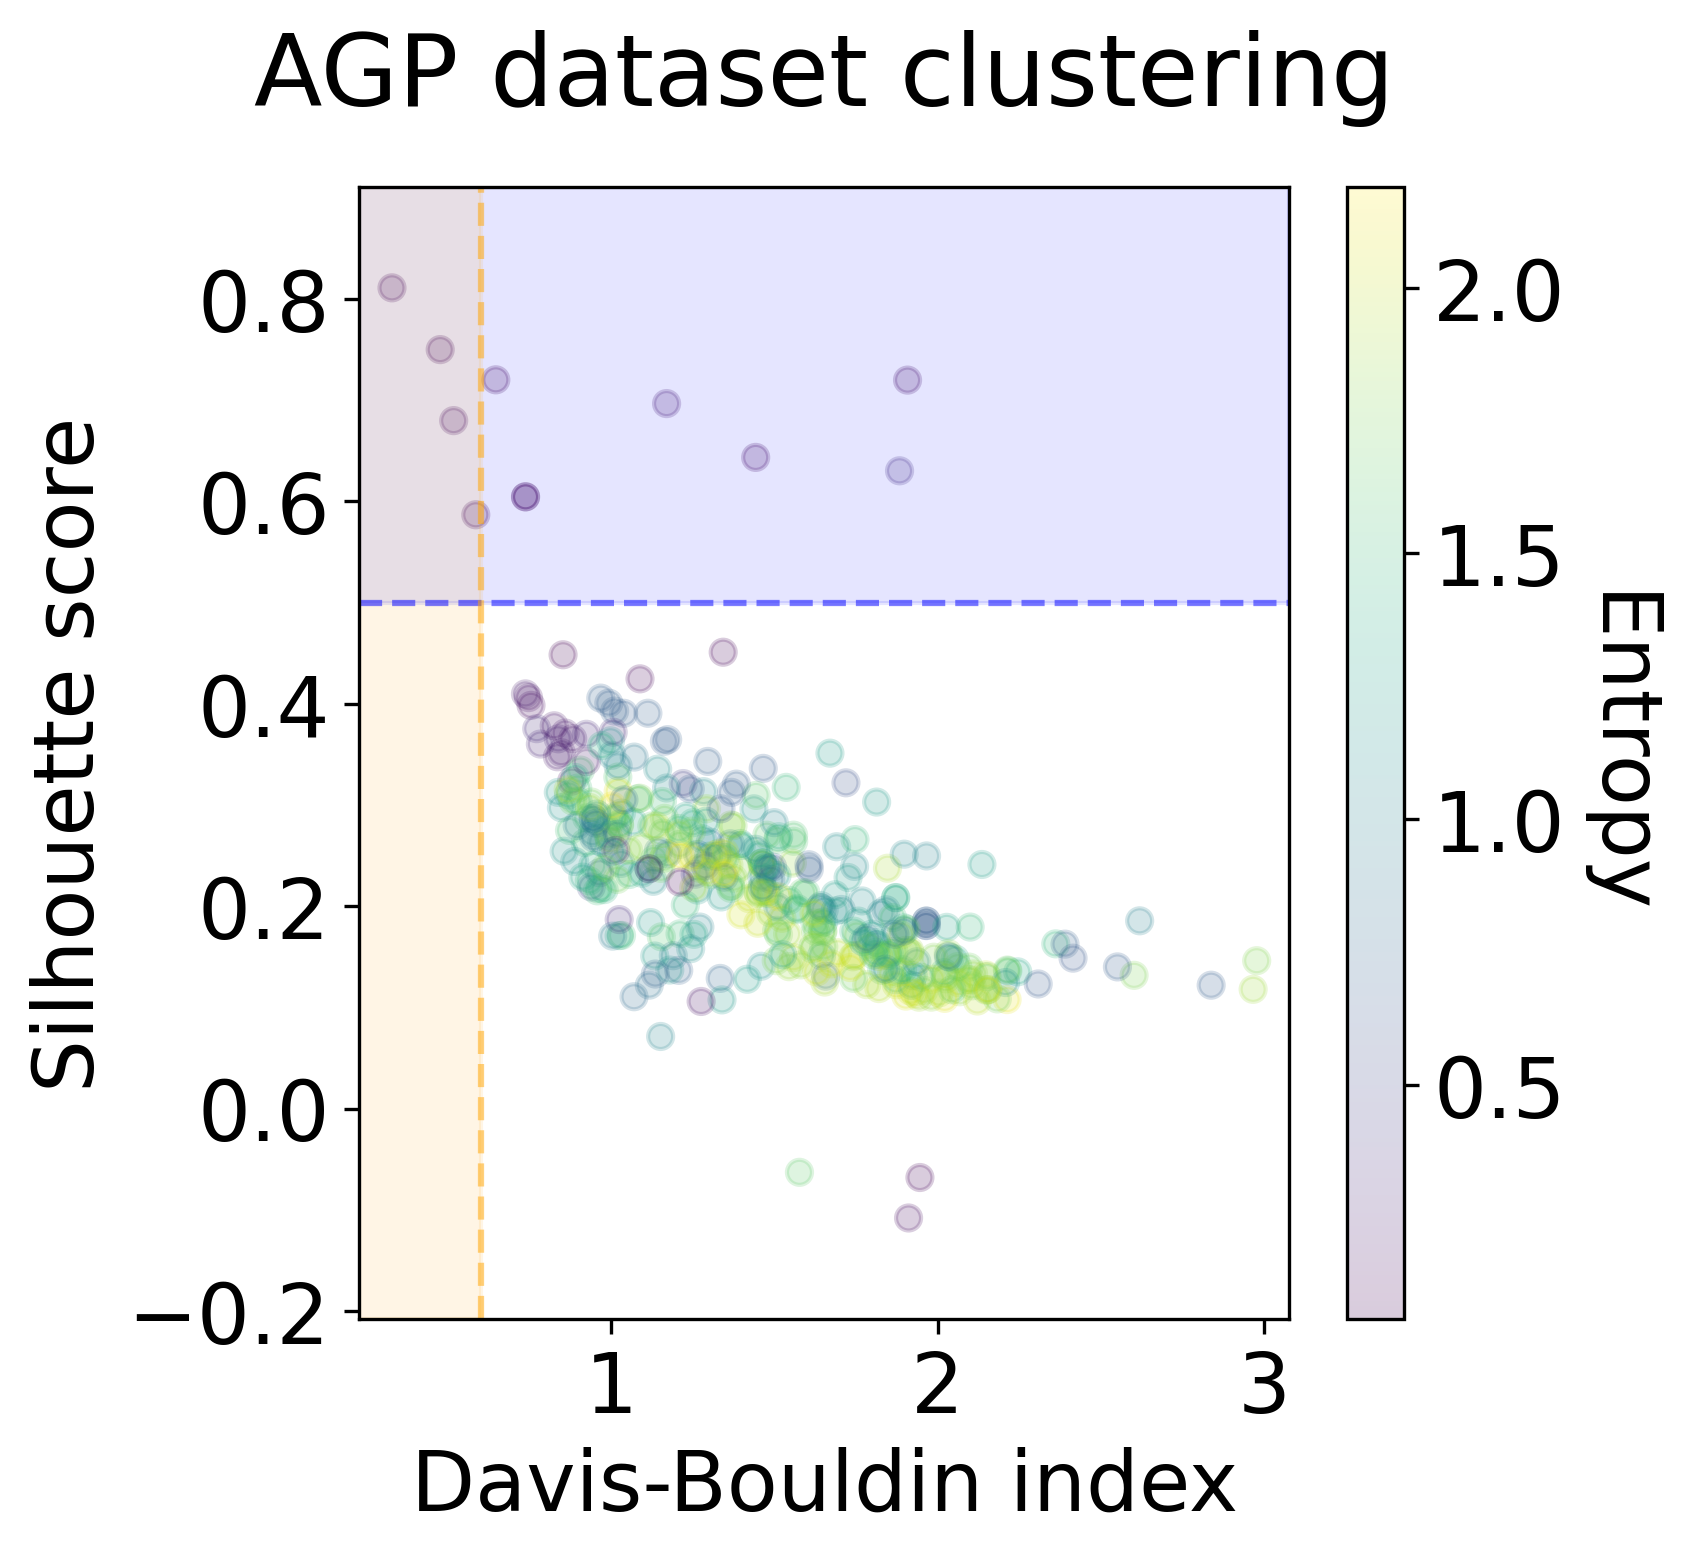

In [117]:
plot_clustering_scatter(df_metrics_AGP_, 
                        x_metric_name='dbind',
                        y_metric_name='silh', 
                        coloring_metric_name='entropy', 
                        title='AGP dataset clustering',
                        y_threshold=SILHOUETTE_THRESH,
                        x_threshold=DBIND_THRESHOLD,
                        y_hue_line=1,
                        x_hue_line=0)

In [118]:
selection_mask_AGP = (df_metrics_AGP_['silh'] > SILHOUETTE_THRESH) * (df_metrics_AGP_['dbind'] < DBIND_THRESHOLD)
df_metrics_AGP_[selection_mask_AGP]

,dbind,silh,dbcv,ps,noise_ratio,entropy,data_used,dist
JS_AGP_o_SpectralClustering_2,0.328027,0.811103,-0.815039,0.161192,0.0,0.07885,0.994007,"[0.9847683520203089, 0.015231647979691136]"
L2_AGP_o_SpectralClustering_2,0.584699,0.58683,-0.699324,0.726873,0.0,0.058868,0.989276,"[0.9893718779891593, 0.010628122010840685]"
lle_AGP_o_SpectralClustering_2,0.475737,0.750078,-0.819951,0.942752,0.0,0.059806,1.0,"[0.9891646277525341, 0.01083537224746592]"
spectral_AGP_o_SpectralClustering_2,0.516935,0.679888,-0.755809,0.748995,0.0,0.092242,1.0,"[0.018524991261796575, 0.9814750087382035]"


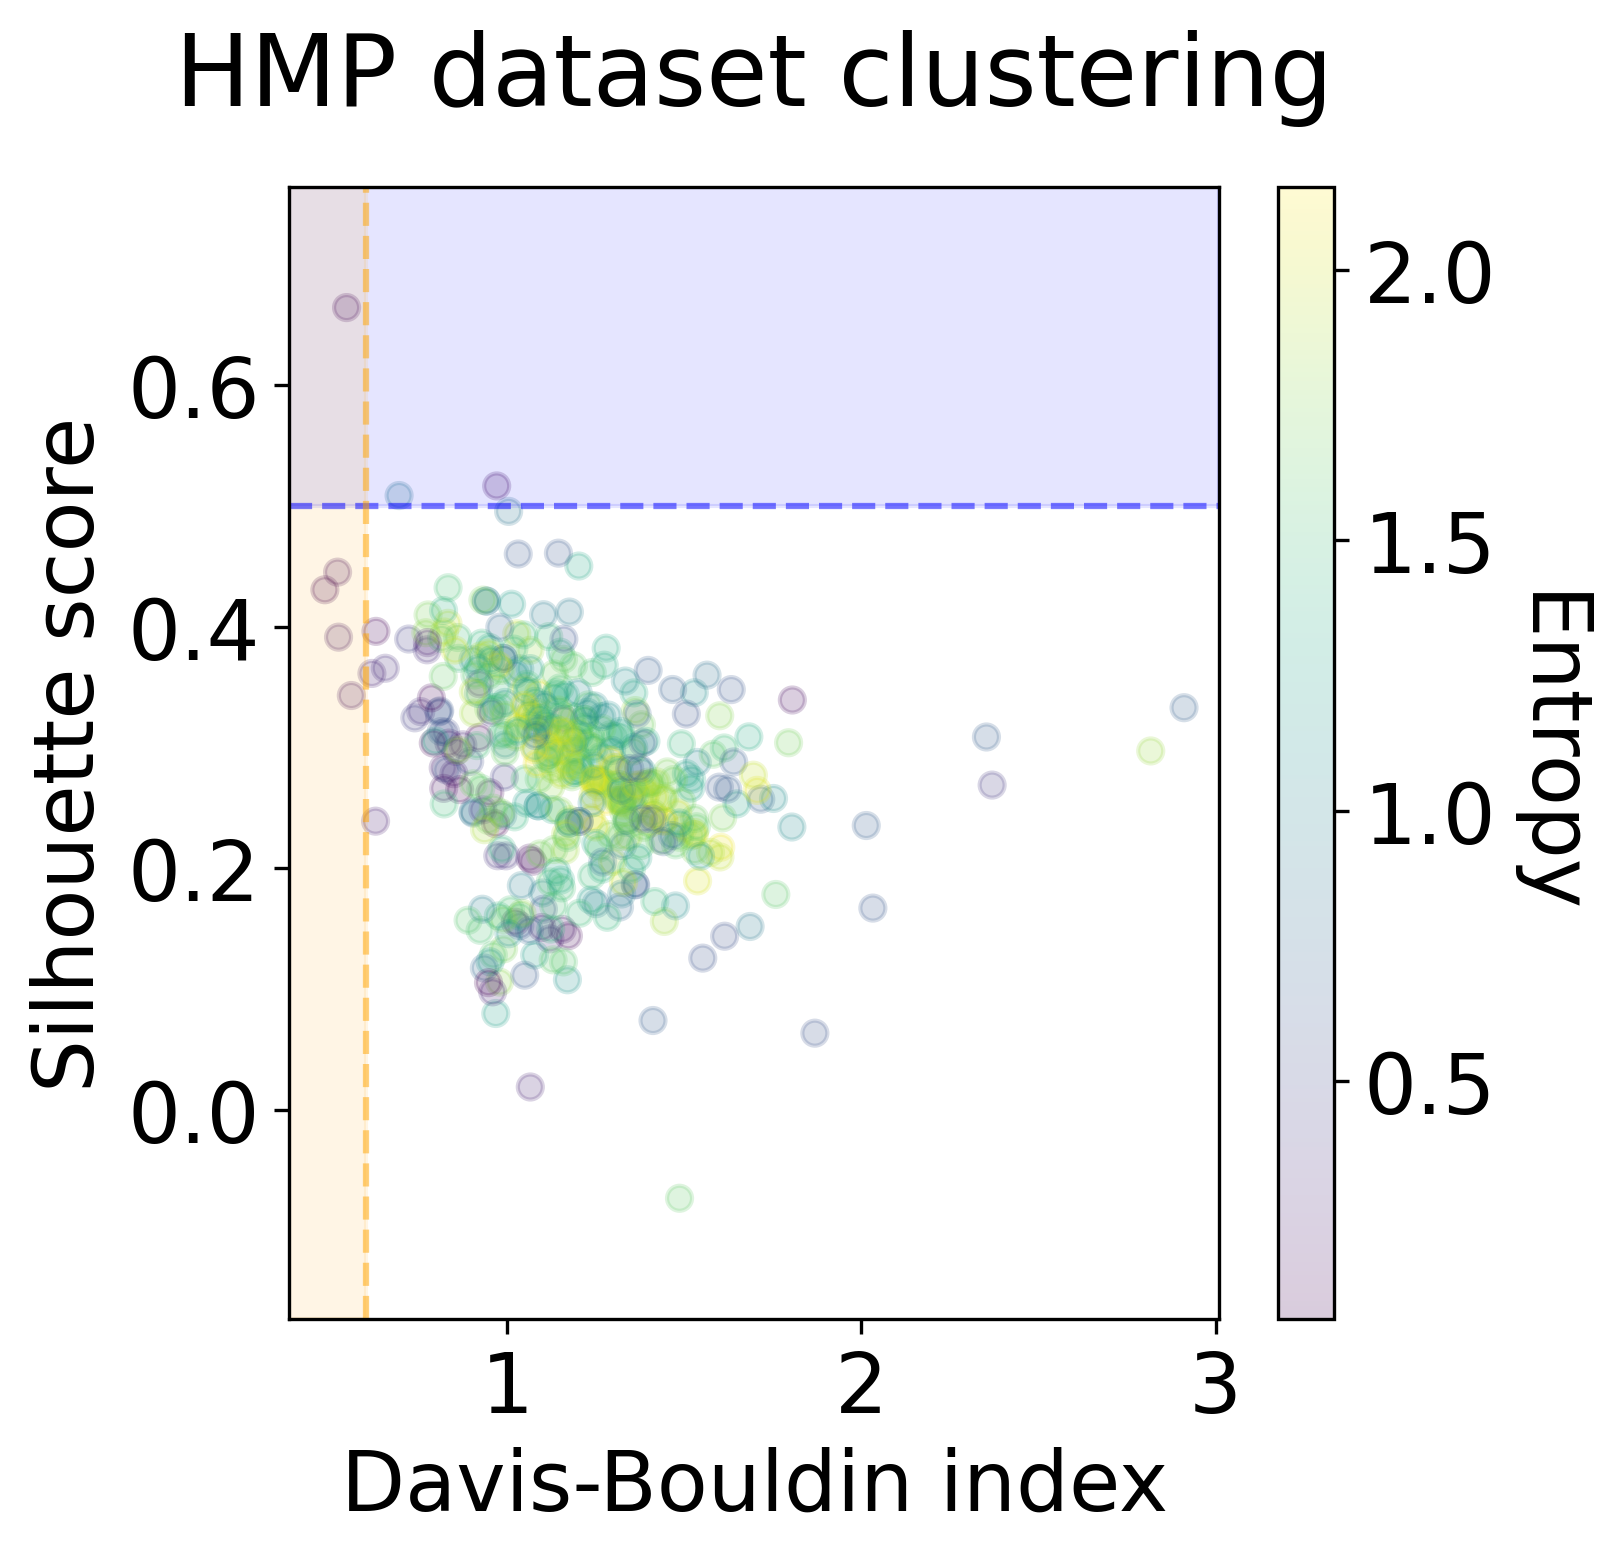

In [119]:
plot_clustering_scatter(df_metrics_HMP_, 
                        x_metric_name='dbind',
                        y_metric_name='silh', 
                        coloring_metric_name='entropy', 
                        title='HMP dataset clustering',
                        y_threshold=SILHOUETTE_THRESH,
                        x_threshold=DBIND_THRESHOLD,
                        y_hue_line=1,
                        x_hue_line=0)

In [120]:
selection_mask_HMP = (df_metrics_HMP_['silh'] > SILHOUETTE_THRESH) * (df_metrics_HMP_['dbind'] < DBIND_THRESHOLD)
df_metrics_HMP_[selection_mask_HMP]

,dbind,silh,dbcv,ps,noise_ratio,entropy,data_used,dist
spectral_HMP_f_HDBSCAN_2,0.54659,0.663826,-0.643712,0.495269,0.017241,0.091288,0.982759,"[0.01828514949345194, 0.981714850506548]"


# DBVC and Prediction Strength, entropy coloring

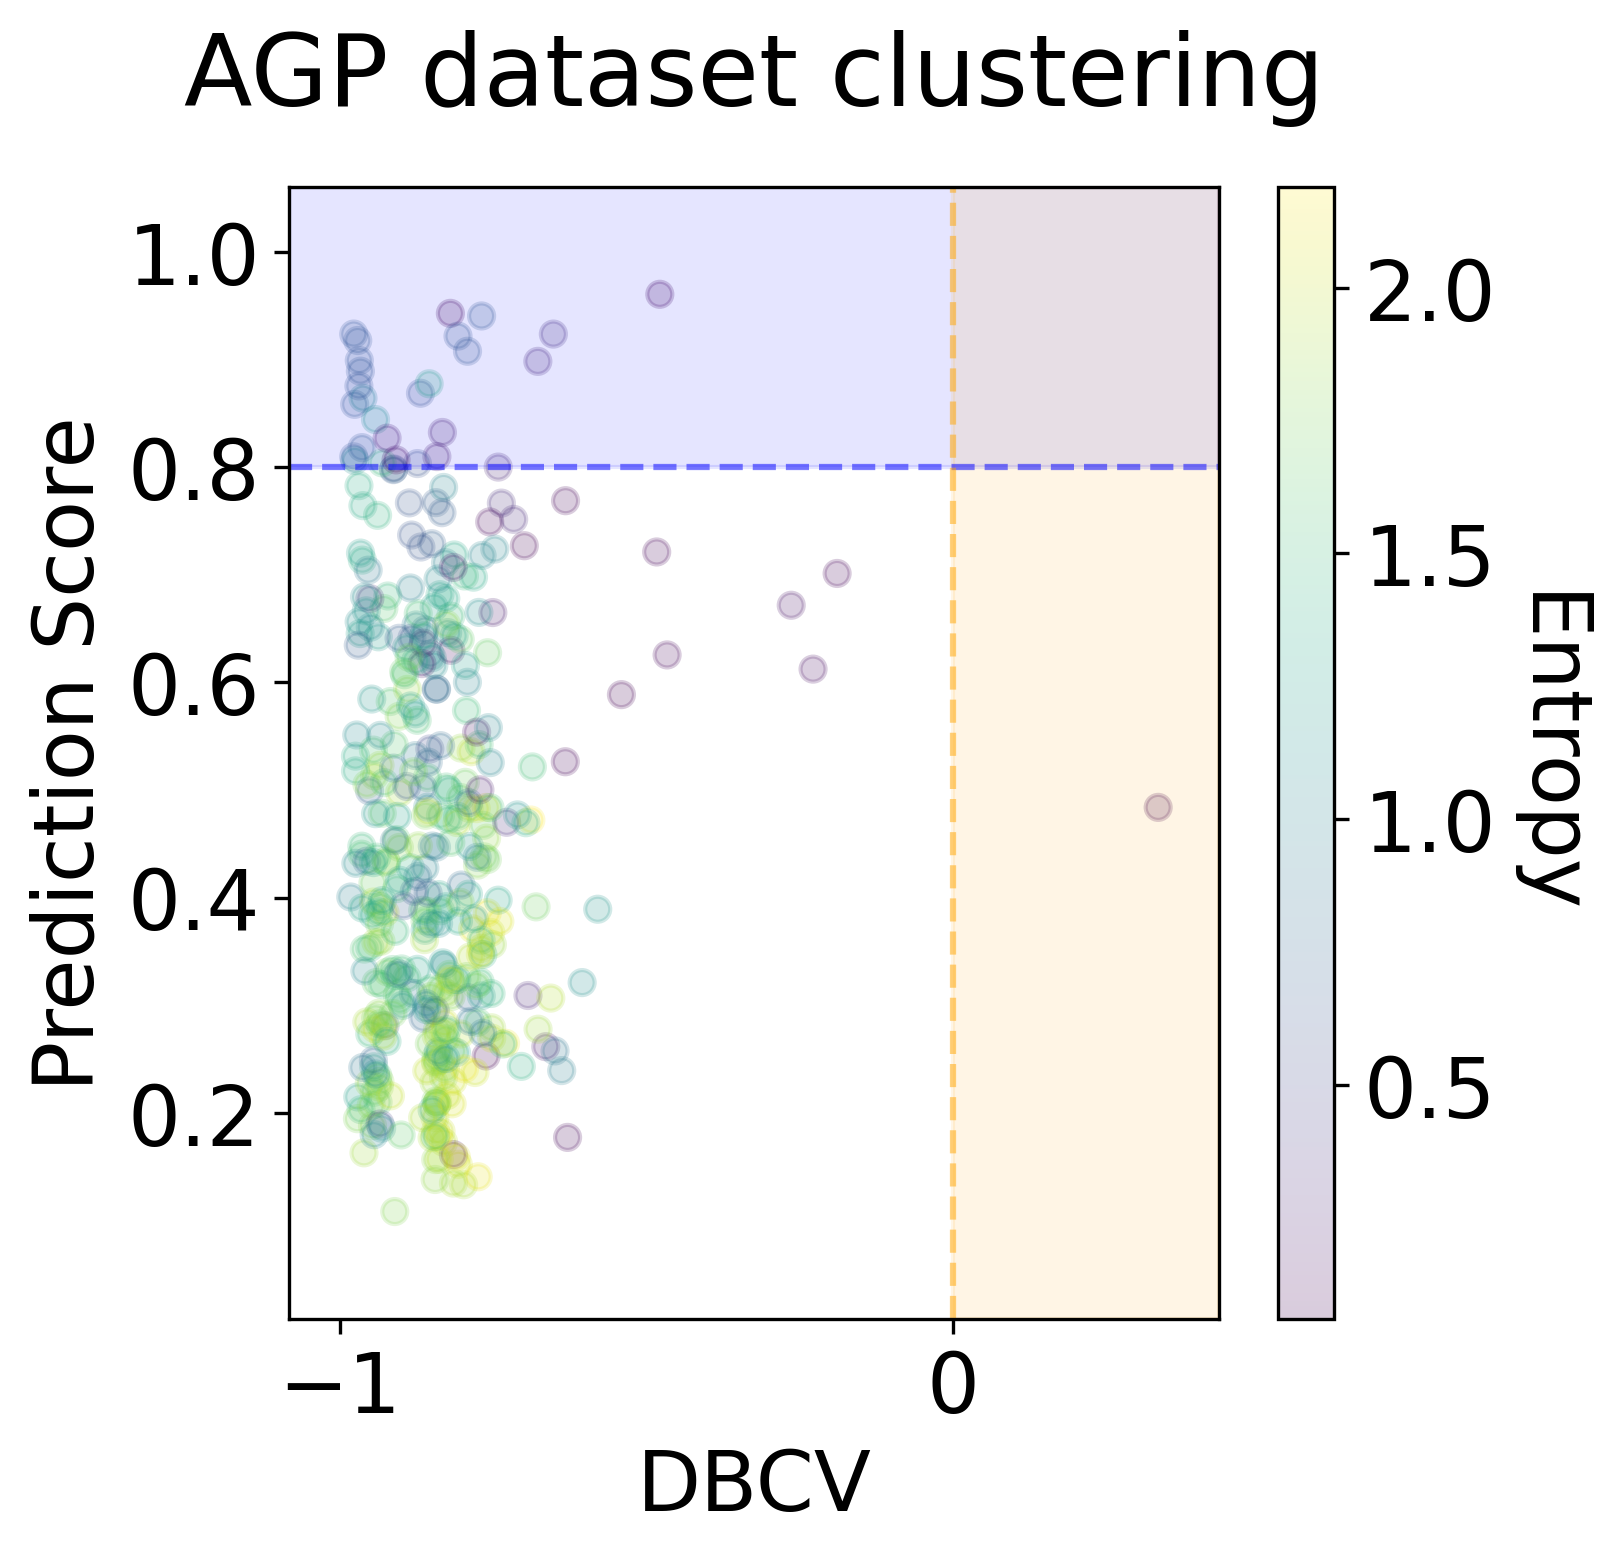

In [121]:
plot_clustering_scatter(df_metrics_AGP_, 
                        x_metric_name='dbcv',
                        y_metric_name='ps', 
                        coloring_metric_name='entropy', 
                        title='AGP dataset clustering',
                        y_threshold=PS_THRESHOLD,
                        x_threshold=DBCV_THRESHOLD,
                        y_hue_line=1.2,
                        x_hue_line=1
                        )

In [122]:
selection_mask_AGP = (df_metrics_AGP_['dbcv'] > DBCV_THRESHOLD) * (df_metrics_AGP_['ps'] > PS_THRESHOLD)
df_metrics_AGP_[selection_mask_AGP]

,dbind,silh,dbcv,ps,noise_ratio,entropy,data_used,dist


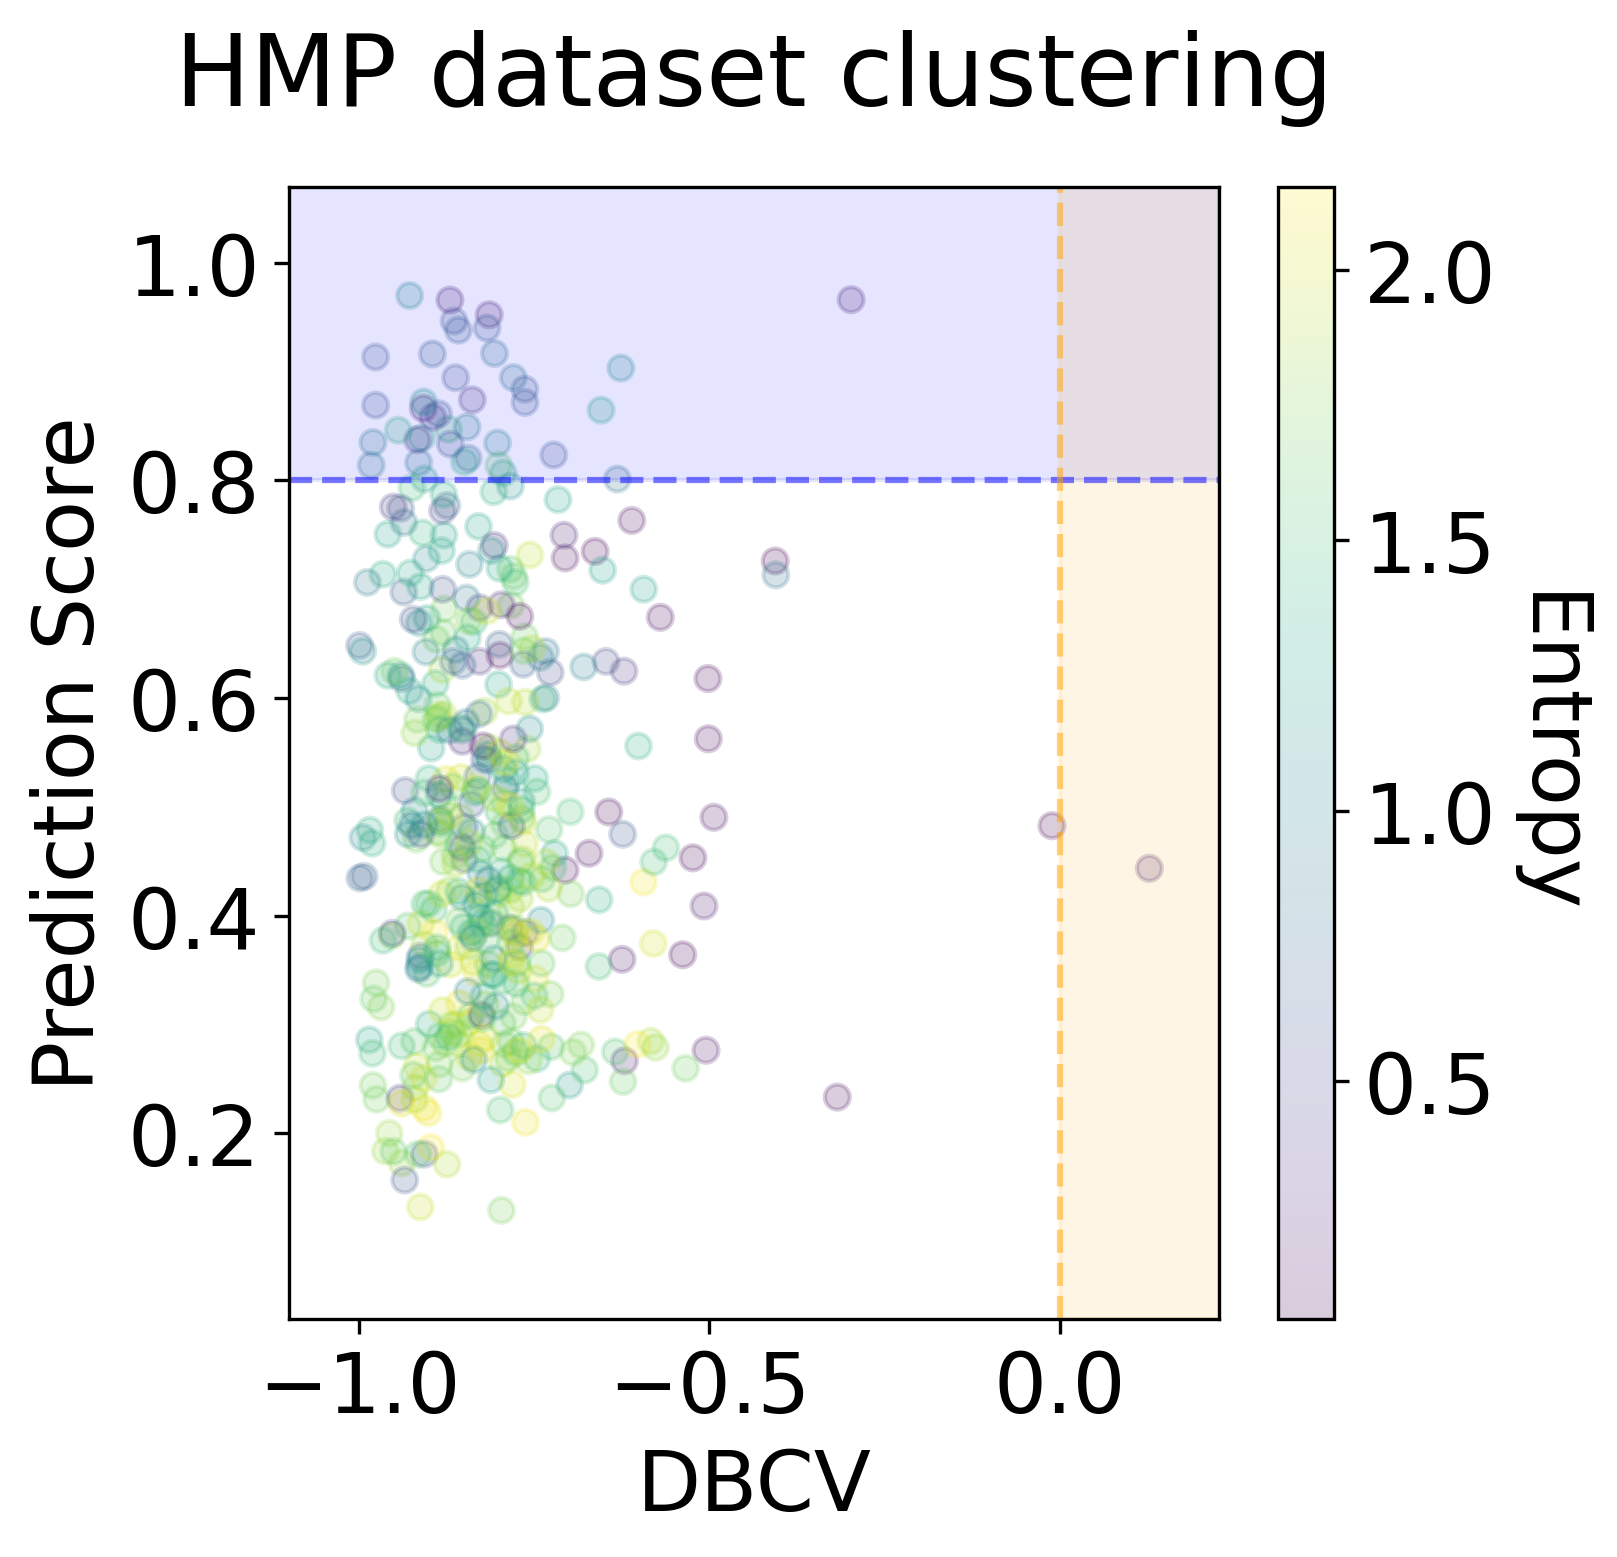

In [123]:
plot_clustering_scatter(df_metrics_HMP_, 
                        x_metric_name='dbcv',
                        y_metric_name='ps', 
                        coloring_metric_name='entropy', 
                        title='HMP dataset clustering',
                        y_threshold=PS_THRESHOLD,
                        x_threshold=DBCV_THRESHOLD,
                        y_hue_line=1.2,
                        x_hue_line=1
                        )

In [124]:
selection_mask_HMP = (df_metrics_HMP_['dbcv'] > DBCV_THRESHOLD) * (df_metrics_HMP_['ps'] > PS_THRESHOLD)
df_metrics_HMP_[selection_mask_HMP]

,dbind,silh,dbcv,ps,noise_ratio,entropy,data_used,dist
